# Inits

In [54]:
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import pickle
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real

# Read in data
Gilbert provides two datasets, one containing all the info about the sgRNAs, other one containing all of what he generated about the annotated genes. Both are imported, and distances between 5' of the PAM and both ends of the primary and secondary TSS sites of the gene are calculated, for usage in the model.

In [55]:
# dataframe containing sequences, targeted genes, and scores
df = pd.read_excel("data/elife-19760-supp1-v2.xlsx")
df = df.rename(columns = {"sgRNA sequence": "sequence",
                          "gene symbol": "gene",
                          "distance_to_CAGE": "distance",
                          "sgRNA length (including PAM)": "length",
                          "PAM genomic coordinate [hg19]" : "PAM_coord",
                          "CRISPRi activity score [Horlbeck et al., eLife 2016]": "score"})

# dataframe containing annotated gene locations
gene_df = pd.read_excel("data/elife-19760-supp2-v2.xlsx")
gene_df = gene_df.rename(columns = {"Primary TSS, 5'": "prim_TSS_5p",
                                    "Primary TSS, 3'": "prim_TSS_3p",
                                    "Secondary TSS, 5'": "sec_TSS_5p",
                                    "Secondary TSS, 3'": "sec_TSS_3p"})

# merging the two, determining distance between PAM and TSS
df = pd.merge(df, gene_df, on = ("gene", "chromosome"), how = "left")
df["prim_TSS_dist5p"] = df["PAM_coord"] - df["prim_TSS_5p"]
df["prim_TSS_dist3p"] = df["PAM_coord"] - df["prim_TSS_3p"]
df["sec_TSS_dist5p"] = df["PAM_coord"] - df["sec_TSS_5p"]
df["sec_TSS_dist3p"] = df["PAM_coord"] - df["sec_TSS_3p"]
df = df[(df["prim_TSS_dist5p"] > -3000) & (df["prim_TSS_dist5p"] < 3000)]

# determine the max sequence length - useful later on (mainly for one hot encoding)
max_len = df["sequence"].apply(len).agg(max)

/tmp/ipykernel_262540/4217778725.py:26: FutureWarning: The provided callable <built-in function max> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  max_len = df["sequence"].apply(len).agg(max)


# Linearizing TSS distance
Gilbert's paper mentions linearizing primary and secondary distance to TSS using an SVR, and then using the outputs of the SVM as variables for the distance from TSS. Not quite sure why this works, or why they need to be linearized.

## Formatting and binning data
Binning is primarily for visualization (data can be quite crowded), but also can be used for fitting to SVR

/tmp/ipykernel_262540/146674775.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby("X_bin")["score"].mean().reset_index()
/tmp/ipykernel_262540/146674775.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby("X_bin")["score"].mean().reset_index()


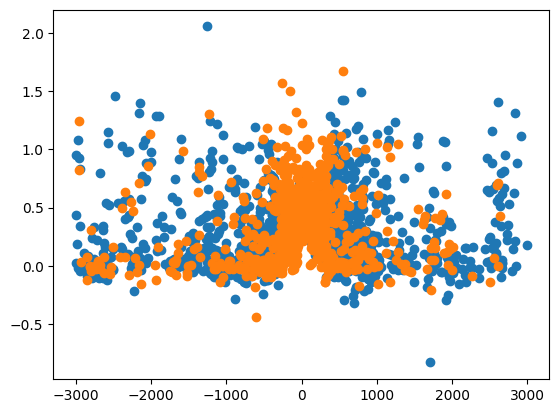

In [56]:
df = df.dropna()
X = df.dropna(subset = "prim_TSS_dist5p").loc[:, ["prim_TSS_dist5p"]]
y = df.dropna(subset = "prim_TSS_dist5p").loc[:, "score"]

# splitting training/test sets
perc_test = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = perc_test, random_state = 42)

def bin_and_average(df, bins):    
    df["X_bin"] = pd.cut(df["prim_TSS_dist5p"], bins = bins)
    
    bin_means = df.groupby("X_bin")["score"].mean().reset_index()
    bin_means["center"] = bin_means["X_bin"].apply(lambda row: row.left + (np.abs(row.left - row.right) / 2))
    
    return bin_means.dropna()

concat_df = pd.concat([X_train, y_train], axis = 1)
num_bins = 50000
binned_df = bin_and_average(concat_df, int((1 - perc_test) * num_bins))

binned_test_df = bin_and_average(pd.concat([X_test, y_test], axis = 1), int(perc_test * num_bins))

plt.scatter(binned_df["center"], binned_df["score"])
plt.scatter(binned_test_df["center"], binned_test_df["score"])

## Fitting model to SVR
Two statements are given - one is to fit to binned data, other is to fit to actual data. GridSearchCV is commented out because it takes a long time and seems to overfit to the existing data, but should probably be messed around with more in the future.

In [57]:
# fitting to binned data
# svr = svm.SVR(kernel = "rbf")
# parameters = {"C": Real(0.001, 100, prior = "log-uniform"),
#               "gamma":Real (1E-8, 1, prior = "log-uniform")}
# grid_svr = BayesSearchCV(svr, parameters, n_jobs = -1, scoring = "neg_mean_squared_error", iters = 50)
# grid_svr.fit(binned_df["center"].to_numpy().reshape(-1, 1), binned_df["score"].to_numpy().reshape(-1, 1))
# with open("models/binned_test_SVR.pk1", "wb") as file:
#     pickle.dump(grid_svr, file)
    
with open("models/binned_test_SVR.pk1", "rb") as file:
    grid_svr = pickle.load(file)
print(f"R^2: {grid_svr.score(binned_test_df['center'].to_numpy().reshape(-1, 1), binned_test_df['score'].to_numpy().reshape(-1, 1))}")

R^2: -0.0787502796751135


## Plotting fit
Plotted with binned values and actual values

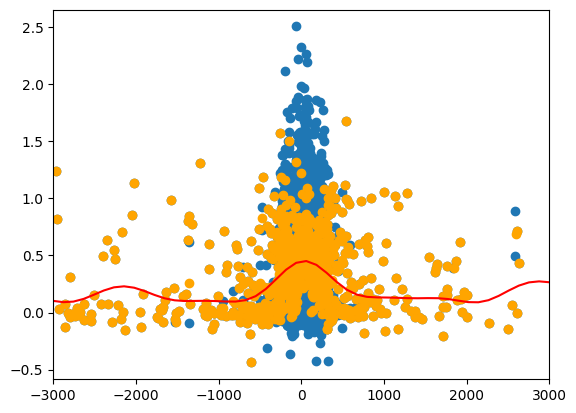

In [58]:
plot_X = np.linspace(-3000, 3000).reshape(-1, 1)
best_svr = grid_svr.best_estimator_
y_pred = best_svr.predict(plot_X)

plt.scatter(X_test, y_test)
plt.scatter(binned_test_df["center"], binned_test_df["score"], color = "orange")
plt.plot(plot_X, y_pred, color = "red")
plt.xlim(-3000, 3000)
plt.show()

## Adding linearized distance for all distances
Adding linearized values (obtained from SVM fit) for all four distance vectors. Plots for each for sanity.

/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


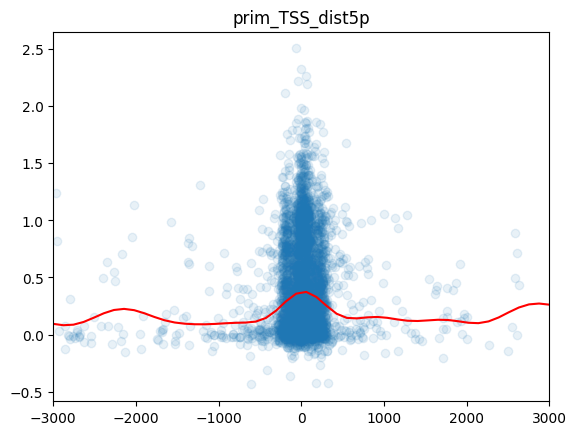

/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


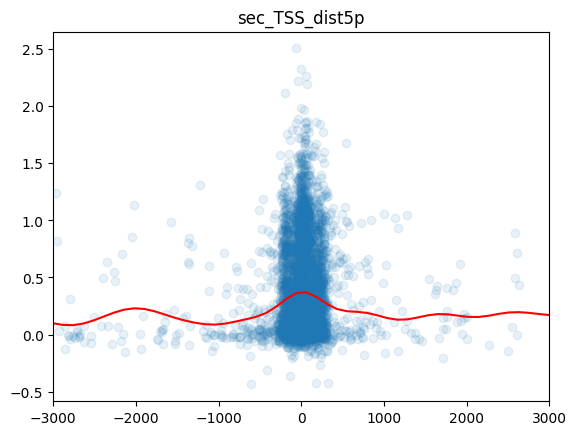

/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


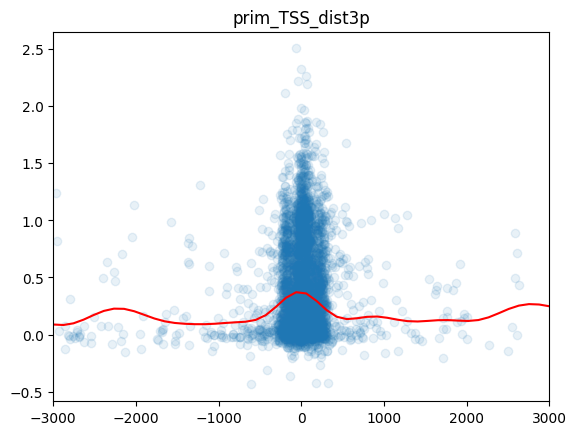

/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/rutecki.ja/.conda/envs/ecc/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


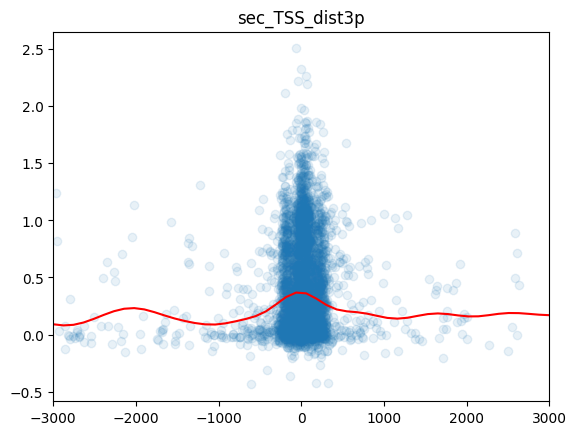

In [59]:
vars = ("prim_TSS_dist5p", "sec_TSS_dist5p", "prim_TSS_dist3p", "sec_TSS_dist3p")

for var in vars:
    # setting up X and y for variable
    X = df.dropna(subset = var).loc[:, [var]]
    y = df.dropna(subset = var).loc[:, "score"]
    
    # splitting training and testing sets based on value defined earlier
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = perc_test, random_state = 42)
    # best_svr.fit(X_train, y_train)
    # with open("models/" + var + "_test_SVR.pk1", "wb") as file:
    #     pickle.dump(best_svr, file)
    
    with open("models/" + var + "_test_SVR.pk1", "rb") as file:
        best_svr = pickle.load(file)
    
    # update original dataframe with normalized values
    df[("norm_" + var)] = best_svr.predict(df[var].to_numpy().reshape(-1, 1))
    
    plot_X = np.linspace(-3000, 3000).reshape(-1, 1)
    y_pred = best_svr.predict(plot_X)

    plt.scatter(X_test, y_test, alpha = 0.1)
    plt.plot(plot_X, y_pred, color = "red")
    plt.xlim(-3000, 3000)
    plt.title(var)
    plt.show()

# Adding GC content

In [60]:
for base in ("A", "C", "T", "G"):
    df[("frac_" + base)] = df.apply(lambda row: row["sequence"].count(base) / row["length"], axis = 1)
    
df["GC_content"] = df["frac_C"] + df["frac_G"]

# One-hot encoding vectors for monomer bases at each position

In [61]:
bps = ["A", "C", "T", "G"]

def encode_monomer(seq, max_len):
    one_hot_vector = np.zeros((max_len, len(bps)))
    
    for i, bp in enumerate(seq):
        if bp in bps:
            one_hot_vector[i, bps.index(base)] = 1
    return one_hot_vector

encoded_monomers = df["sequence"].apply(lambda x: encode_monomer(x, max_len))
temp_cols = {}

for i in range(max_len):
    for j, base in enumerate(bps):
        temp_cols[f"pos_{i+1}_{base}"] = encoded_monomers.apply(lambda x: x[i, j])
        
df = pd.concat([df, pd.DataFrame(temp_cols)], axis = 1)

# One-hot encoding vectors for dimers at each position

In [62]:
combo_bps = []
for i, b1 in enumerate(bps):
    for j, b2 in enumerate(bps):
        combo_bps.append(b1 + b2)

def encode_dimer(seq, max_len):
    one_hot_vector = np.zeros((max_len, len(combo_bps)))
    
    # iterating over two bases at a time, in order
    for i in range(len(seq) - 1):
        dimer = seq[i] + seq[i + 1]
        if dimer in combo_bps:
            one_hot_vector[i, combo_bps.index(dimer)] = 1
    return one_hot_vector

encoded = df["sequence"].apply(lambda x: encode_dimer(x, max_len))
temp_cols = {}

for i in range(max_len):
    for j, bases in enumerate(combo_bps):
        temp_cols[f"pos_{i+1}{i+2}_{bases}"] = encoded.apply(lambda x: x[i, j])
        
df = pd.concat([df, pd.DataFrame(temp_cols)], axis = 1)

# Running off-target analysis for each sgRNA

## Generating input.txt
Commented out for now because this takes ~2 hours to run on the current dataset

In [63]:
# # normalize all sgRNAs to have the same length as the max length sgRNA (by adding Ns in front)
# max_len = df["sequence"].apply(len).max()

# def normalize_str_len(str, max_len):
#     while len(str) < max_len:
#         str = "N" + str
#     return(str)

# df["sequence"] = df["sequence"].apply(normalize_str_len, args = (max_len,))

# # preparing input strings for cas-offinder
# pam = "NGG"
# full_pam = ("N" * max_len) + pam

# co_input = f"../genomes/human_hg19\n{full_pam} 2 1"
# for i, seq in enumerate(df["sequence"], start = 1):
#     co_input = co_input + f"\n{seq}NNN 3 Seq{i}"

# # write input string to input.txt for cas-offinder
# with open("input.txt", "w") as file:
#     file.write(co_input)

# # running subprocess for cas-offinder (WARNING: MAY TAKE A VERY LONG TIME TO RUN)
# subprocess.run(f".\cas-offinder input.txt G output.txt")

## Reading output.txt, adding MMs to dataframe
Currently going with the following approach:

- Count the number of off-targets with 1, 2, and 3 mismatches
- Sum them together for each sequence
- Add those three as three additional features

While this does treat all OTs as equal, which is not correct, ideally it should show some correlation between low numbers of off-target and higher scores, with less mismatches having higher impacts

In [64]:
# co_output = pd.read_csv("output.txt", sep = "\t", comment = "#", header = None)
# co_output.columns = ["WT", "chromosome", "posn", "OT", "dir", "mismatches"]

# temp_df = {}

# # loop through each all numbers of mismatches and count how many each sequence has for each number
# for MM in (1, 2, 3):
#     temp_df[f"{MM}_MMs"] = df["sequence"].apply(lambda seq: len(co_output.loc[(co_output["WT"].str.contains(seq)) &
#                                                                          (co_output["mismatches"] == MM)]))
# with open("models/off_targets.pk1", "wb") as file:
#     pickle.dump(temp_df, file)
    
with open("models/off_targets.pk1", "rb") as file:
    temp_df = pickle.load(file)
df = pd.concat([df, pd.DataFrame(temp_df)], axis = 1)

# Secondary structure, minimum free energy

## Determine structure and MFE for each, add it to dataframe

In [65]:
import ViennaRNA as vr

def structure_mfe(seq):
    fc = vr.fold_compound(seq)
    return fc.mfe()

structs_mfes = df["sequence"].apply(lambda x: pd.Series(structure_mfe(x)))
df = pd.concat([df, pd.DataFrame({"struct": structs_mfes[0],
                                  "mfe": structs_mfes[1]})],
               axis = 1)

## Apply one hot encoding to the structure

In [66]:
parts = [".", "(", ")"]

def encode_struct(struct, max_len):
    one_hot_vector = np.zeros((max_len, len(parts)))
    
    for i, part in enumerate(struct):
        if part in parts:
            one_hot_vector[i, parts.index(part)] = 1
    return one_hot_vector

encoded_structs = df["struct"].apply(lambda x: encode_struct(x, max_len))
temp_cols = {}

for i in range(max_len):
    for j, part in enumerate(parts):
        temp_cols[f"pos_{i+1}_{part}"] = encoded_structs.apply(lambda x: x[i, j])
        
df = pd.concat([df, pd.DataFrame(temp_cols)], axis = 1)

# Determining nucleotide homopolymers

In [98]:
def longest_homopolymer(seq):
    max_count = {"longest_" + bp: 0 for bp in bps}
    
    for bp in bps:
        current_count = 0
        for base in seq:
            if bp == base:
                current_count += 1
                if current_count > max_count["longest_" + bp]:
                    max_count["longest_" + bp] = current_count
            else:
                current_count = 0
    return max_count
    
temp_df = df["sequence"].apply(longest_homopolymer)
df = pd.concat([df, temp_df.apply(pd.Series)], axis = 1)

# Writing dataframe to .csv file

In [99]:
df.to_csv("structured_set.csv", index = False)